# Урок 4. Тематическое моделирование. EM-алгоритм

## Домашнее задание

Скачиваем датасет (источник): положительные, отрицательные.

рабочие ссылки с твитами<br>
https://disk.yandex.ru/i/v5HM-ENiGXZVpQ<br>
https://disk.yandex.ru/i/koR5eMCToCZS2Q

1. объединить в одну выборку (это только для твитов), для роспотребнадзора сформировать датасет из вопросов
2. провести исследование и выявить тематики о которых говорят в твитах (для твитов), а для роспотребнадзора так же выявить тематики о которых люди пишут проанализировать
3. сделать визуализацию кластеров тематик
4. проинтерпритировать получившиеся тематики

### Подключение библиотек

In [1]:
!pip install stop_words

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for stop-words: filename=stop_words-2018.7.23-py3-none-any.whl size=32911 sha256=d04861512f0a6078f272a74bafe36bcfed183bdf516bbe28517da2be3aa49fef
  Stored in directory: /root/.cache/pip/wheels/fb/86/b2/277b10b1ce9f73ce15059bf6975d4547cc4ec3feeb651978e9
Successfully built stop-words


In [2]:
!pip install pymorphy2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 55 kB 2.2 MB/s 
     |████████████████████████████████| 8.2 MB 24.2 MB/s 


In [21]:
!pip install pyLDAvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 8.9 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=6cc968e40d2926f0e761ac5f4be6a381778d5d8421fa43a86aa9c886e1f6d9f8
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyLDAvis


In [26]:
import pandas as pd
import numpy as np

import re
from stop_words import get_stop_words
from pymorphy2 import MorphAnalyzer

import nltk
from nltk.tokenize import word_tokenize

from tqdm.notebook import tqdm

from gensim.models import *
from gensim import corpora

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

import matplotlib.pyplot as plt
%matplotlib inline

In [28]:
import warnings
warnings.filterwarnings("ignore") 

In [4]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

### Загрузка и подготовка данных

Загрузка и объединение датасетов с положительными и отрицательными твитами

In [5]:
df_positive = pd.read_csv('/content/drive/MyDrive/positive.csv', sep=';', usecols = [3], names = ['tweet'])
df_positive.head()

,tweet
0,"@first_timee хоть я и школота, но поверь, у на..."
1,"Да, все-таки он немного похож на него. Но мой ..."
2,RT @KatiaCheh: Ну ты идиотка) я испугалась за ...
3,"RT @digger2912: ""Кто то в углу сидит и погибае..."
4,@irina_dyshkant Вот что значит страшилка :D\nН...


In [6]:
df_negative = pd.read_csv('/content/drive/MyDrive/negative.csv', sep=';', usecols = [3], names = ['tweet'])
df_negative.head()

,tweet
0,на работе был полный пиддес :| и так каждое за...
1,"Коллеги сидят рубятся в Urban terror, а я из-з..."
2,@elina_4post как говорят обещаного три года жд...
3,"Желаю хорошего полёта и удачной посадки,я буду..."
4,"Обновил за каким-то лешим surf, теперь не рабо..."


In [7]:
df = df_positive.append(df_negative)
df.head()

,tweet
0,"@first_timee хоть я и школота, но поверь, у на..."
1,"Да, все-таки он немного похож на него. Но мой ..."
2,RT @KatiaCheh: Ну ты идиотка) я испугалась за ...
3,"RT @digger2912: ""Кто то в углу сидит и погибае..."
4,@irina_dyshkant Вот что значит страшилка :D\nН...


Препроцессинг твитов

In [8]:
stopwords = set(get_stop_words("ru"))

In [9]:
morpher = MorphAnalyzer()

In [10]:
def preprocess_txt(line):
    line = line.lower() # переводим в нижний регистр
    line = re.sub(r'[^\w\s]', ' ', line) # убираем знаки пунктуации
    line = re.sub(" \d+", " ", line) # убираем числа
    line = re.sub(r'rt*', '', line) # убираем rt
    words = word_tokenize(line) # токенизация
    words = [morpher.parse(word)[0].normal_form for word in words] # лемматизация
    words = [word for word in words if len(word)>3] # убираем слова длинной меньше 3 символов
    words = [word for word in words if word not in stopwords] # убираем стоп слова
   
    return words

In [12]:
preprocessed_text = list(tqdm(map(preprocess_txt, df['tweet']), total=len(df)))

  0%|          | 0/226834 [00:00<?, ?it/s]

In [13]:
df['preprocessed_text'] = preprocessed_text
df.head()

,tweet,preprocessed_text
0,"@first_timee хоть я и школота, но поверь, у на...","[fist_timee, школотый, поверь, самый, общество..."
1,"Да, все-таки он немного похож на него. Но мой ...","[таки, похожий, мальчик, равно, хороший]"
2,RT @KatiaCheh: Ну ты идиотка) я испугалась за ...,"[katiacheh, идиотка, испугаться]"
3,"RT @digger2912: ""Кто то в углу сидит и погибае...","[digge2912, угол, сидеть, погибать, голод, пор..."
4,@irina_dyshkant Вот что значит страшилка :D\nН...,"[iina_dyshkant, страшилка, блин, посмотреть, ч..."


### Модель LDA

Векторизация документов

In [18]:
dictionary = corpora.Dictionary(df['preprocessed_text'])

dictionary.filter_extremes(no_below = 10, no_above = 0.9, keep_n=None) # игнорируем слова, которые встречаются реже 10 раз или составляют более 0.9 словаря 
dictionary.save('tweets.dict')


In [19]:
corpus = [dictionary.doc2bow(text) for text in df['preprocessed_text']]
corpora.MmCorpus.serialize('tweets.model', corpus)

Обучение модели

In [20]:
%%time
lda = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=20, chunksize=50, update_every=1, passes=2)

CPU times: user 6min 21s, sys: 5.43 s, total: 6min 27s
Wall time: 6min 30s


In [23]:
%%time
vis_data = gensimvis.prepare(lda, corpus, dictionary)
pyLDAvis.display(vis_data)

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


CPU times: user 15.2 s, sys: 275 ms, total: 15.5 s
Wall time: 18.6 s


Перплексия и когерентность

In [29]:
coherence_model_lda = CoherenceModel(model=lda, texts=df['preprocessed_text'], dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()

print('Персплексия: ', np.exp(lda.log_perplexity(corpus)))
print('Средняя когерентность: ', coherence_lda)

Персплексия:  5.7688787927027444e-05
Средняя когерентность:  0.3022560278211944


Подбор количества тем

  0%|          | 0/7 [00:00<?, ?it/s]

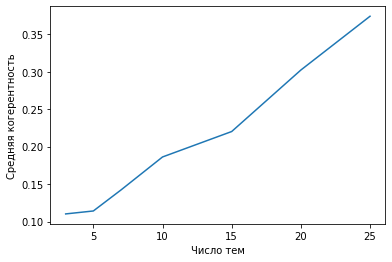

In [30]:
topics_list = [3, 5, 7, 10, 15, 20, 25]
coherences = []

for num in tqdm(topics_list):
    lda = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=num, chunksize=50, update_every=1, passes=2)
    coherences.append(CoherenceModel(model=lda, texts=df['preprocessed_text'], dictionary=dictionary, coherence='c_v').get_coherence())

plt.plot(topics_list, coherences)
plt.xlabel("Число тем")
plt.ylabel("Средняя когерентность")
plt.show()

Обучение модели с новым количеством тем

In [31]:
lda_15 = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=5, chunksize=50, update_every=1, passes=2)
vis_data = gensimvis.prepare(lda_15, corpus, dictionary)
pyLDAvis.display(vis_data)

Тема 1: слова - делать
писать
болеть
пойти
хотеться
мама
сделать

Тема 2: слова - http
знать
любить
смотреть
скучать
сидеть`



Тема 3: слова - завтра
блин
вообще
идти
большой
школа

Тема 4: слова - свой
самый
говорить
никто
жалко
учить

Тема 5: слова - спать
плохо
утро
ночь
понимать
неделя